# Dataset
"The dataset I chose is the affairs dataset that comes with Statsmodels. It was derived from a survey of women in 1974 by Redbook magazine, in which married women were asked about their participation in extramarital affairs. More information about the study is available in a 1978 paper from the Journal of Political Economy."

# Description of Variables
The dataset contains 6366 observations of 9 variables:

- **rate_marriage**: woman's rating of her marriage (1 = very poor, 5 = very good)
- **age**: woman's age
- **yrs_married**: number of years married
- **children**: number of children
- **religious**: woman's rating of how religious she is (1 = not religious, 4 = strongly religious)
- **educ**: level of education (9 = grade school, 12 = high school, 14 = some college, 16 = college graduate, 17 = some graduate school, 20 = advanced degree)
- **occupation**: woman's occupation (1 = student, 2 = farming/semi-skilled/unskilled, 3 = "white collar", 4 = teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 = professional with advanced degree)
- **occupation_husb**: husband's occupation (same coding as above)
- **affairs**: time spent in extra-marital affairs

# Problem Statement
"I decided to treat this as a classification problem by creating a new binary variable affair (did the woman have at least one affair?) and trying to predict the classification for each woman.

Skipper Seabold, one of the primary contributors to Statsmodels, did a similar classification in his Statsmodels demo at a Statistical Programming DC Meetup. However, he used Statsmodels for the classification (whereas I'm using scikit-learn), and he treated the occupation variables as continuous (whereas I'm treating them as categorical)."

# Data

In [8]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [30, 15]
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [2]:
df_data = sm.datasets.fair.load_pandas().data

In [4]:
df_data['affair_flag'] = (df_data['affairs']>0).astype(int)

In [6]:
df_data.groupby('affair_flag').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair_flag,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


- looks like women who have affairs tend to rate their marriages lower (obvious)

In [7]:
df_data.groupby('rate_marriage').mean()

,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair_flag
rate_marriage,,,,,,,,,
1,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,1.201671,0.747475
2,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,1.615745,0.635057
3,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,1.371281,0.550856
4,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.674837,0.322926
5,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.348174,0.181446


- looking at the table, we can see:
    - younger people rate their marriage higher
    - the shorter the marriage, the better the rating
    - the fewer the children, the higher the rating
    - the most poorly rated marriages don't have the longest affairs, but are more likely to have them
    - religion, education, occupation, and husband's occupation are not an important factor

# Visualization

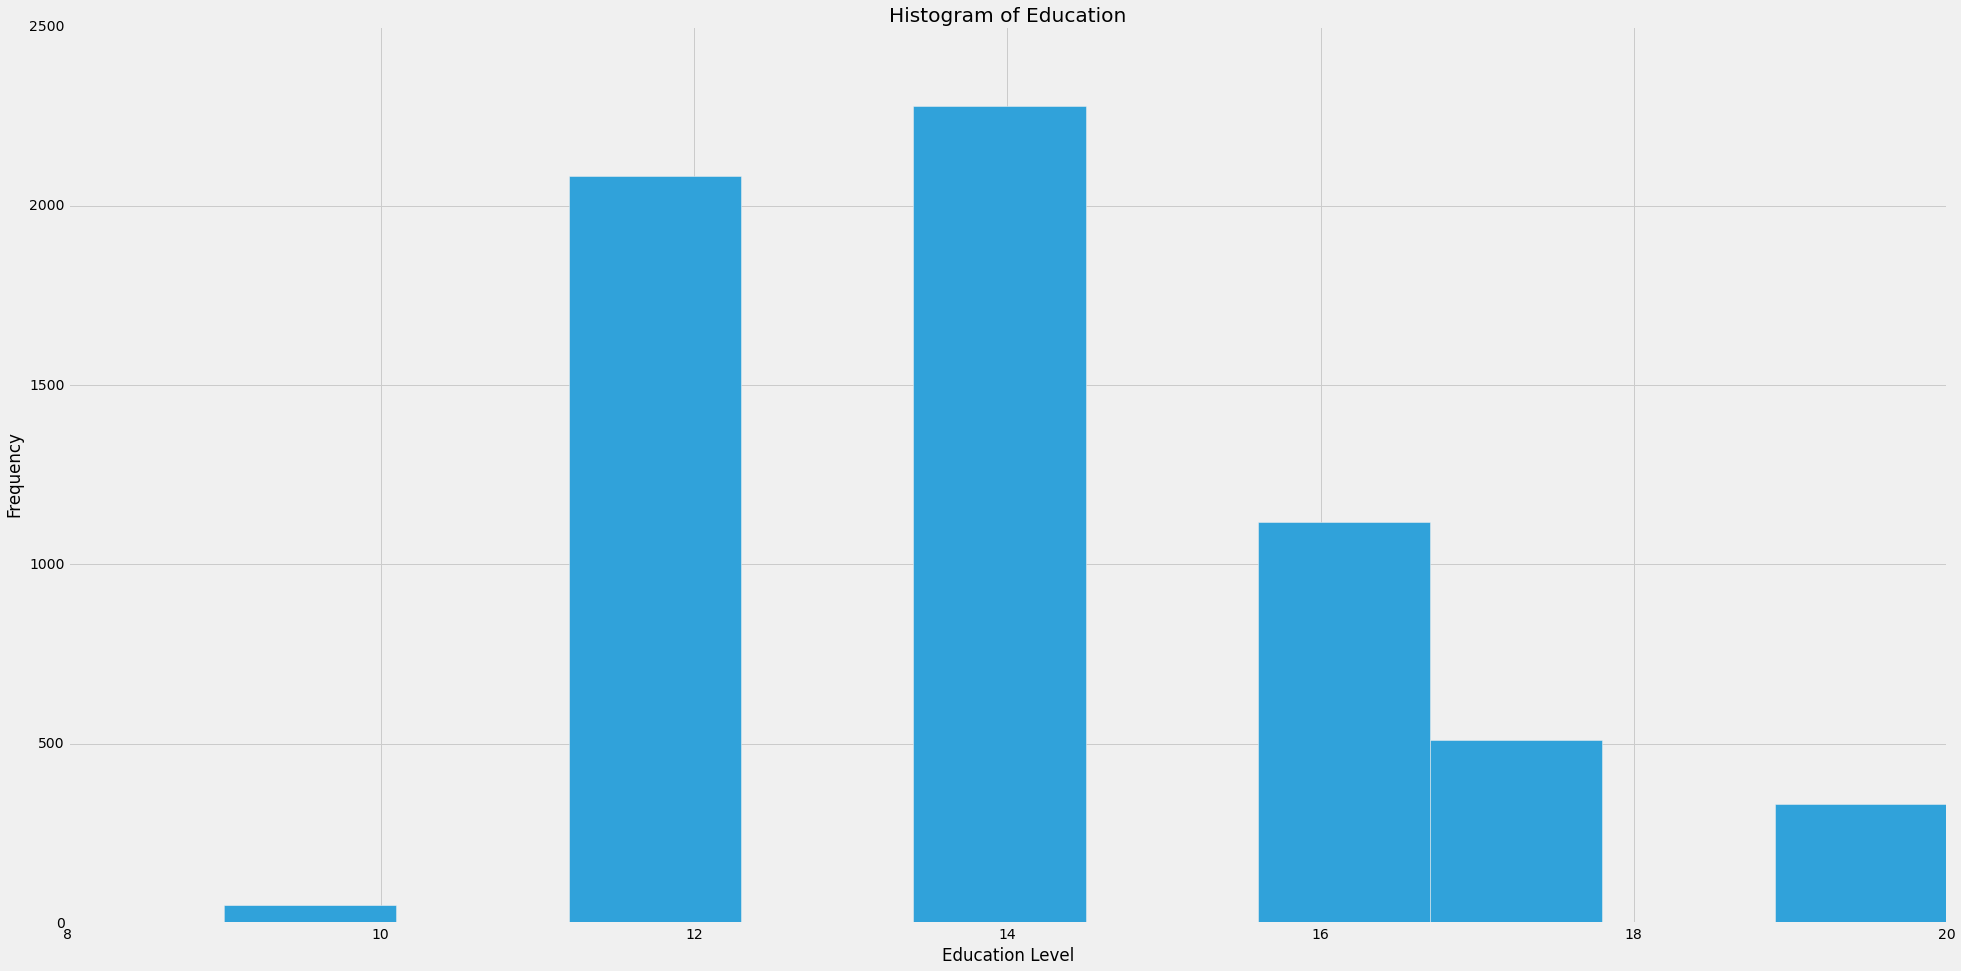

In [10]:
# histogram of education
df_data.educ.hist()
plt.title('Histogram of Education')
plt.xlabel('Education Level')
plt.ylabel('Frequency')

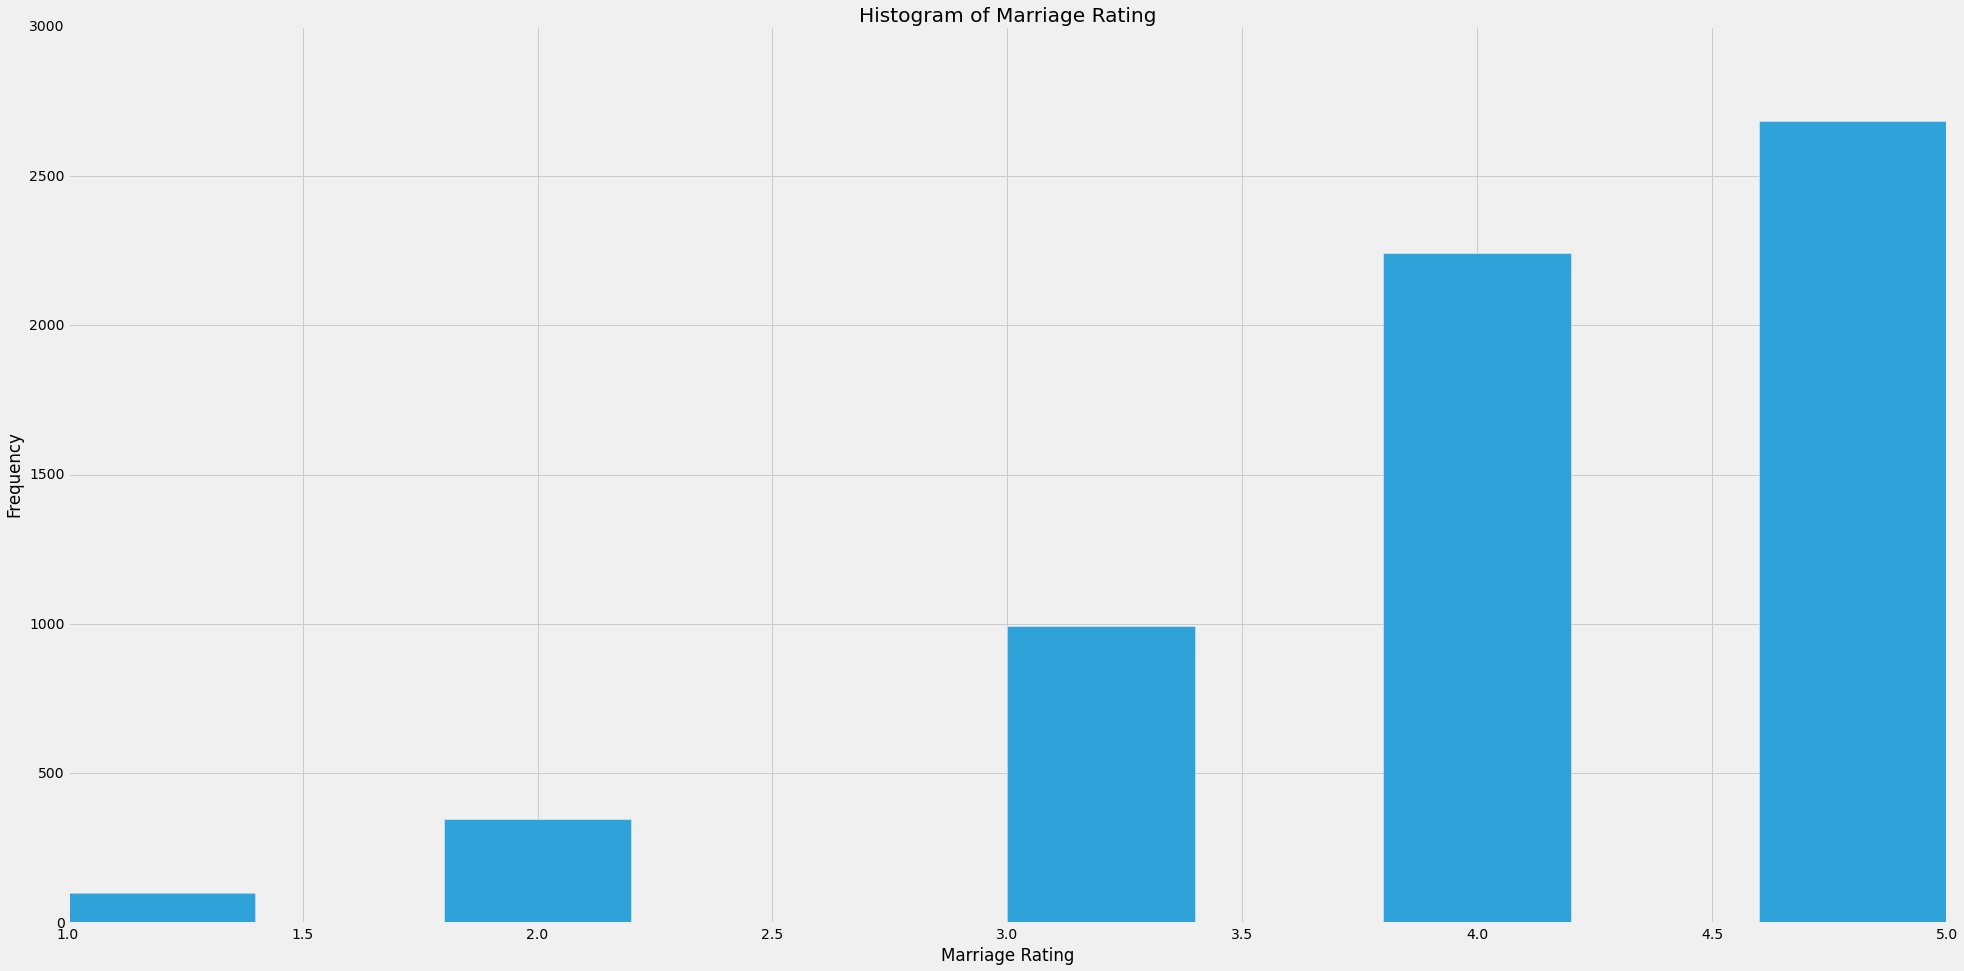

In [12]:
# histogram of marriage rating
df_data.rate_marriage.hist()
plt.title('Histogram of Marriage Rating')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

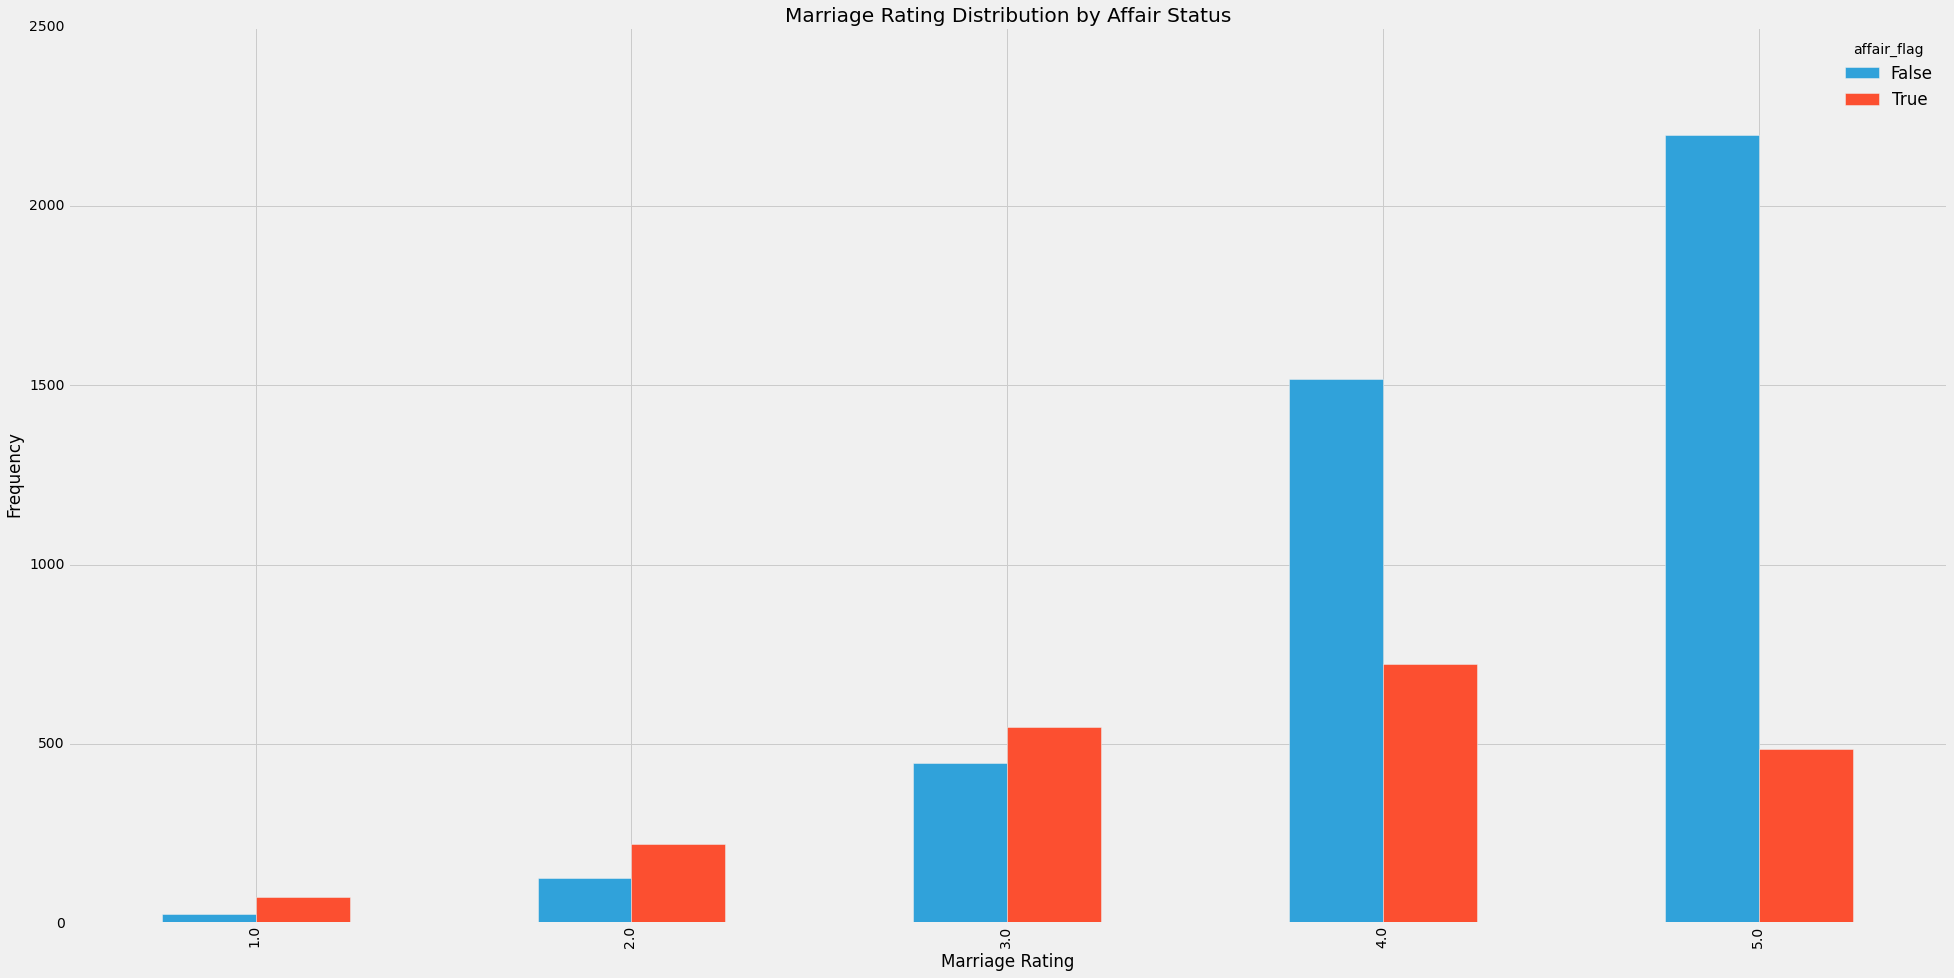

In [15]:
# barplot of marriage rating grouped by affair (True or False)
pd.crosstab(df_data.rate_marriage, df_data.affair_flag.astype(bool)).plot(kind='bar')
plt.title('Marriage Rating Distribution by Affair Status')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

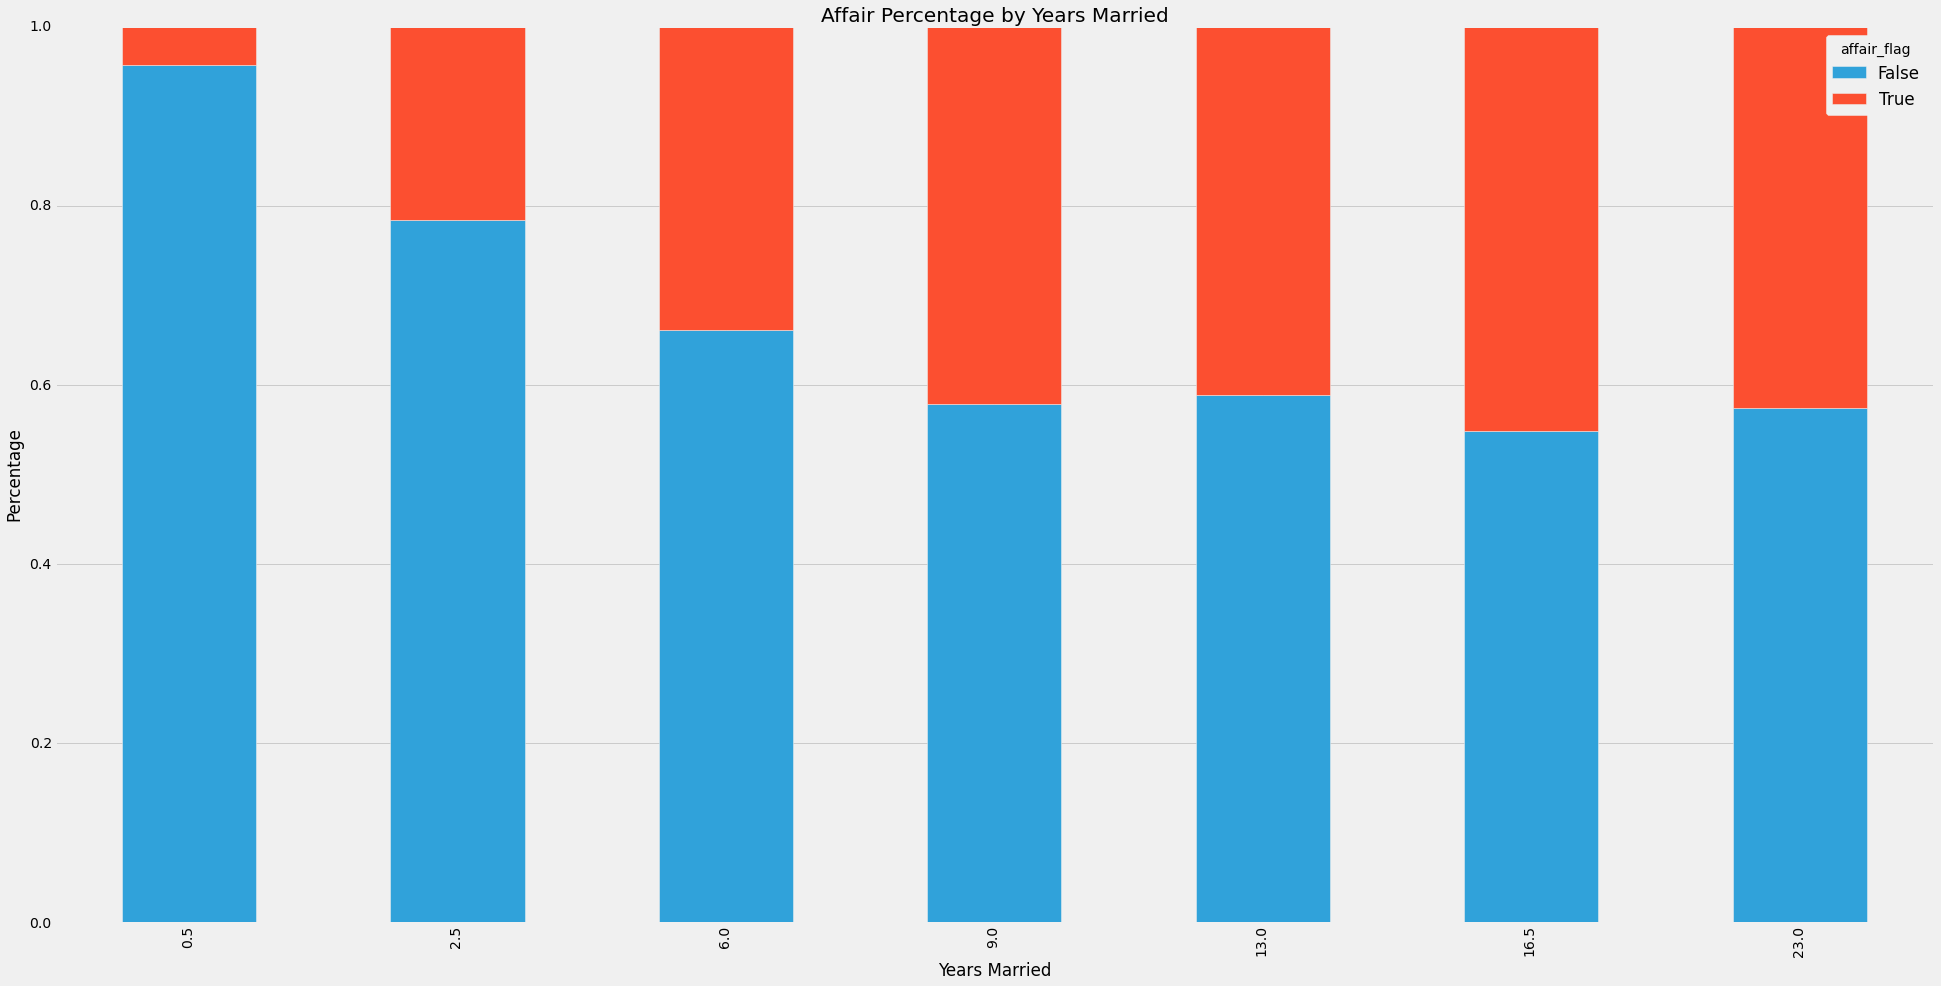

In [16]:
affair_yrs_married = pd.crosstab(df_data.yrs_married, df_data.affair_flag.astype(bool))
affair_yrs_married.div(affair_yrs_married.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Affair Percentage by Years Married')
plt.xlabel('Years Married')
plt.ylabel('Percentage')

# Prepare Data for Logistic Regression

- adding an intercept column
- add dummy variables for occupation and occupation_husb
- uses formula from http://patsy.readthedocs.io/en/latest/

In [19]:
# create dataframes with an intercept column and dummy variables for
# occupation and occupation_husb
y, X = dmatrices('affair_flag ~ rate_marriage + age + yrs_married + children + \
                  religious + educ + C(occupation) + C(occupation_husb)',
                  df_data, return_type="dataframe")

In [22]:
X.head()

,Intercept,C(occupation)[T.2.0],C(occupation)[T.3.0],C(occupation)[T.4.0],C(occupation)[T.5.0],C(occupation)[T.6.0],C(occupation_husb)[T.2.0],C(occupation_husb)[T.3.0],C(occupation_husb)[T.4.0],C(occupation_husb)[T.5.0],C(occupation_husb)[T.6.0],rate_marriage,age,yrs_married,children,religious,educ
0,1,1,0,0,0,0,0,0,0,1,0,3,32,9.0,3,3,17
1,1,0,1,0,0,0,0,0,1,0,0,3,27,13.0,3,1,14
2,1,0,1,0,0,0,0,0,0,1,0,4,22,2.5,0,1,16
3,1,0,0,0,1,0,0,0,0,1,0,4,37,16.5,4,3,16
4,1,0,1,0,0,0,0,0,1,0,0,5,27,9.0,1,1,14


In [23]:
#renaming the dummy (aka categorical) columns
X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2',
                        'C(occupation)[T.3.0]':'occ_3',
                        'C(occupation)[T.4.0]':'occ_4',
                        'C(occupation)[T.5.0]':'occ_5',
                        'C(occupation)[T.6.0]':'occ_6',
                        'C(occupation_husb)[T.2.0]':'occ_husb_2',
                        'C(occupation_husb)[T.3.0]':'occ_husb_3',
                        'C(occupation_husb)[T.4.0]':'occ_husb_4',
                        'C(occupation_husb)[T.5.0]':'occ_husb_5',
                        'C(occupation_husb)[T.6.0]':'occ_husb_6'})

In [24]:
X.head()

,Intercept,occ_2,occ_3,occ_4,occ_5,occ_6,occ_husb_2,occ_husb_3,occ_husb_4,occ_husb_5,occ_husb_6,rate_marriage,age,yrs_married,children,religious,educ
0,1,1,0,0,0,0,0,0,0,1,0,3,32,9.0,3,3,17
1,1,0,1,0,0,0,0,0,1,0,0,3,27,13.0,3,1,14
2,1,0,1,0,0,0,0,0,0,1,0,4,22,2.5,0,1,16
3,1,0,0,0,1,0,0,0,0,1,0,4,37,16.5,4,3,16
4,1,0,1,0,0,0,0,0,1,0,0,5,27,9.0,1,1,14


In [25]:
#flattening the y-column for scikitlearn
y = np.ravel(y)

In [26]:
y

array([ 1.,  1.,  1., ...,  0.,  0.,  0.])

# Logistic Regression
- running the regression on the entire data set
    - checking its accuracy

In [27]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.72588752748978946

73% accuracy seems good, but what's the null error rate?

In [28]:
# what percentage had affairs?
y.mean()

0.32249450204209867

Only 32% of the women had affairs, which means that you could obtain 68% accuracy by always predicting "no". So we're doing better than the null error rate, but not by much.

So 73% isn't actually great

In [29]:
# examine the coefficients
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Intercept,[1.48986214923]
1,occ_2,[0.188041521947]
2,occ_3,[0.498919714822]
3,occ_4,[0.250640990053]
4,occ_5,[0.838976932692]
5,occ_6,[0.83400830339]
6,occ_husb_2,[0.190579893537]
7,occ_husb_3,[0.297779843131]
8,occ_husb_4,[0.161353493872]
9,occ_husb_5,[0.187717838451]


## Model Evaluation w. Testing Set & Training Set
Let's instead split the data into a training set and a testing set.

In [30]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [31]:
# predict class labels for the test set
predicted = model2.predict(X_test)
print predicted

[ 1.  0.  0. ...,  0.  0.  0.]


In [32]:
# generate class probabilities
probs = model2.predict_proba(X_test)
print probs

[[ 0.3514634   0.6485366 ]
 [ 0.90955084  0.09044916]
 [ 0.72567333  0.27432667]
 ..., 
 [ 0.55727385  0.44272615]
 [ 0.81207041  0.18792959]
 [ 0.747346    0.252654  ]]


- The classifier is predicting a 1 (having an affair) any time the probability in the second column is greater than 0.5.

- Now let's generate some evaluation metrics.

In [33]:
# generate evaluation metrics
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.729842931937
0.745950606951


- The accuracy is 73%, which is the same as we experienced when training and predicting on the same data.

- We can also see the confusion matrix and a classification report with other metrics.

In [34]:
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)

[[1169  134]
 [ 382  225]]
             precision    recall  f1-score   support

        0.0       0.75      0.90      0.82      1303
        1.0       0.63      0.37      0.47       607

avg / total       0.71      0.73      0.71      1910



## Model Evaluation Using Cross-Validation
Now let's try 10-fold cross-validation, to see if the accuracy holds up more rigorously.

In [35]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.72100313  0.70219436  0.73824451  0.70597484  0.70597484  0.72955975
  0.7327044   0.70440252  0.75157233  0.75      ]
0.724163068551


Looks good. It's still performing at 73% accuracy.